Load Needed Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle

import dash
from dash import Dash, Input, Output, State, dcc, html, callback

import xgboost as xgb
from xgboost import XGBRegressor

import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler


### FUNCTIONS CREATED FOR THE PROJECT

In [6]:
def prepare_data_split(df, test_size, random_state, target_feature):
    '''
    Fuunction Split a dataset(df) Train/Validation
    
    return the train, Validation and Test dataset with their corresponding targer variable
    '''
    df_train, df_test = train_test_split(df, test_size= test_size, random_state=random_state)
    
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = np.log1p(df_train[target_feature].values)
    y_test = np.log1p(df_test[target_feature].values)
    
    del df_train[target_feature]
    del df_test[target_feature]
    
    print(f"Length of Train: {len(df_train)}, Length of Test: {len(df_test)}")
    print()
    return df_train, y_train, df_test, y_test


def wrangle(filename):
    # Load Training Dataset
    df = pd.read_csv(filename)
    
    # Fill missing values numerical dataset with median value
    for cols in df.select_dtypes("number").drop(columns = ["ID", "price"]).columns:
        medn = df[cols].median()
        df[cols].fillna(medn, inplace = True)
        
        
    df['luxury_indicator'] = df['bedroom'] / df['bathroom']
    df['size_indicator'] = df['bedroom'] + df['bathroom'] + df['parking_space']
    df['luxury_by_size_indicator'] = df['luxury_indicator'] * df['size_indicator']
    
    # Drop all other missing values (categorical features)
    df.dropna(inplace = True)

    #delete unnecceassary column    
    del df["ID"] 
    
    df = population_density(df)
    df = region_loc(df)
    return df
    

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
    
def population_density(df):
    
    population_level_1 = ['Anambra', 'Enugu', 'Imo', 'Lagos']
    population_level_2 = ['Abia', 'Kano', 'Rivers']
    population_level_3 = ['Akwa Ibom', 'Ebonyi', 'Ekiti', 'Osun']
    population_level_4 = ['Katsina', 'Ogun', 'Ondo']
    population_level_5 = ['Bauchi', 'Delta', 'Jigawa', 'Oyo']
    population_level_6 = ['Bayelsa', 'Edo', 'Gombe']
    population_level_7 = ['Cross River', 'Kaduna', 'Plateau', 'Sokoto']
    population_level_8 = ['Kebbi', 'Kogi', 'Zamfara']
    population_level_9 = ['Adamawa', 'Benue', 'Kwara', 'Nasarawa']
    population_level_10 = ['Borno', 'Niger', 'Taraba', 'Yobe']

    df['population_density_loc'] = df['loc'].apply(lambda x: "pop_level_10" if x in population_level_1
                                                   else "pop_level_9" if x in population_level_2
                                                   else "pop_level_8" if x in population_level_3
                                                   else "pop_level_7" if x in population_level_4
                                                   else "pop_level_6" if x in population_level_5
                                                   else "pop_level_5" if x in population_level_6
                                                   else "pop_level_4" if x in population_level_7
                                                   else "pop_level_3" if x in population_level_8
                                                   else "pop_level_2" if x in population_level_9
                                                   else "pop_level_1" if x in population_level_10
                                                   else "pop_level_0")
    return df
    
def region_loc(df):
    south_east = ['Anambra', 'Enugu', 'Imo', 'Abia', 'Ebonyi']
    south_west = ['Lagos', 'Ekiti', 'Osun', 'Ogun', 'Ondo', 'Oyo']
    south_south = ['Akwa Ibom', 'Rivers', 'Delta', 'Edo', 'Cross River', 'Bayelsa']
    north_west = ['Katsina', 'Kano', 'Jigawa', 'Kebbi', 'Zamfara', 'Niger', 'Kaduna', 'Sokoto']
    north_east = ['Bauchi', 'Gombe', 'Borno', 'Adamawa', 'Taraba', 'Yobe']
    north_central = ['Plateau', 'Kogi', 'Benue', 'Kwara', 'Nasarawa']

    df['region_loc'] = df['loc'].apply(lambda x: "south_east" if x in south_east
                                       else "south_west" if x in south_west
                                       else "south_south" if x in south_south
                                       else "north_west" if x in north_west
                                       else "north_east" if x in north_east
                                       else "north_central" if x in north_central
                                       else "0")
    return df
    

def outliers(X, y):
    # Automatically detect ouliers and remove
    lof = LocalOutlierFactor()
    outliers = lof.fit_predict(X)

    # select all rows that are not outliers
    mask = outliers != -1
    X_train, y_train = X[mask], y[mask]
    return X_train, y_train


def cat_encoder(X_train, X_val):
    # Applying the DictVectorizer

    dv = DictVectorizer(sparse = False)

    train_dicts = X_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)

    val_dicts = X_val.to_dict(orient='records')
    X_val = dv.transform(val_dicts)
        
    #Save Encoder to disk
    with open("dicv.pkl", "wb") as f:
        pickle.dump(dv, f)
    return X_train, X_val

def min_max_scaler(X_train, X_val):
    # scale the dataset
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    #Save Encoder to disk
    with open("scale.pkl", "wb") as f:
        pickle.dump(scaler, f)
    return X_train, X_val


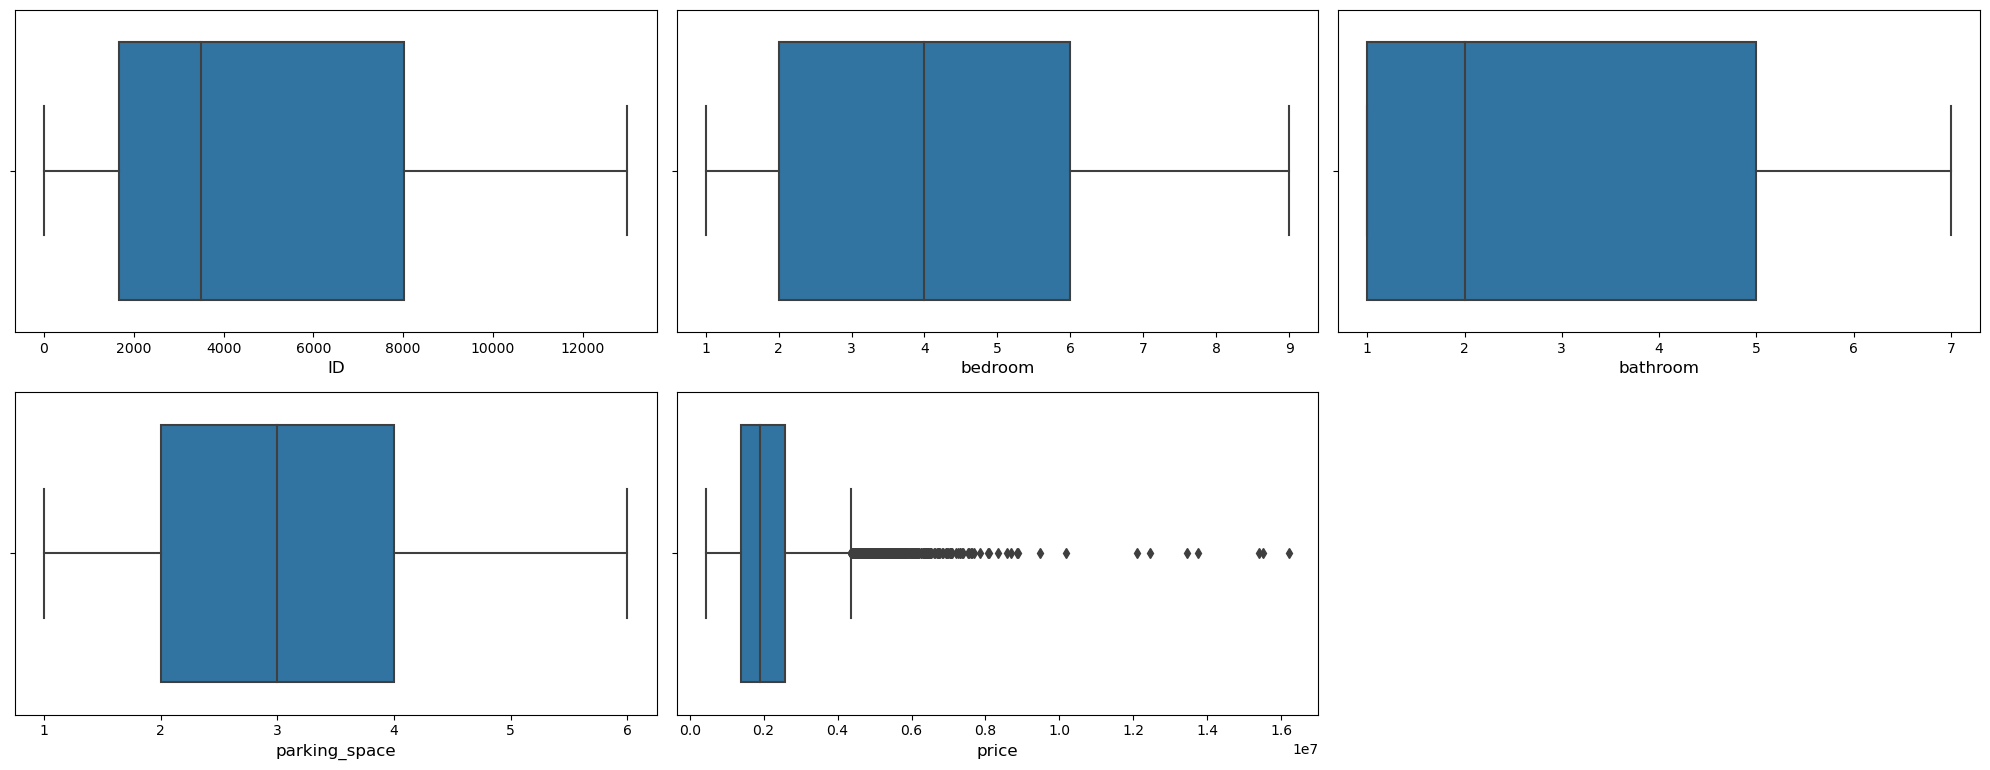

In [13]:
# Checking for outliers

plt.figure(figsize=(20, 15))

# Filter numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

for i, col in enumerate(numeric_columns):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x=df[col])
    plt.xlabel(col, size=12)

plt.tight_layout()
plt.show()


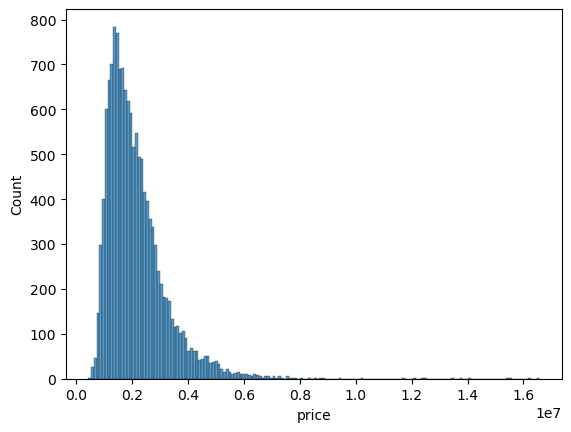

In [33]:
# Checking the distribution of the target variable

sns.histplot(df.price);

In [5]:
df = pd.read_csv("Housing_dataset_train.csv")
df.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [27]:
df.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [28]:
for cols in df.select_dtypes("number").drop(columns = ["ID", "price"]).columns:
    medn = df[cols].median()
    df[cols].fillna(medn, inplace = True)

In [29]:
df.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom             0
bathroom            0
parking_space       0
price               0
dtype: int64

In [30]:
df.dropna(inplace = True)

In [31]:
df["loc"].value_counts()

Cross River    317
Imo            311
Anambra        310
Benue          309
Kaduna         309
Yobe           307
Zamfara        307
Borno          306
Plateau        301
Kano           301
Oyo            301
Ondo           300
Ogun           298
Ebonyi         298
Niger          297
Gombe          296
Kebbi          295
Nasarawa       295
Katsina        292
Jigawa         289
Enugu          288
Bauchi         288
Sokoto         287
Ekiti          286
Osun           286
Adamawa        285
Kwara          285
Bayelsa        284
Taraba         281
Kogi           279
Rivers         278
Delta          277
Abia           276
Lagos          274
Akwa Ibom      273
Edo            265
Name: loc, dtype: int64

In [82]:
# Load dataset

test_size = 0.2
random_state = 1
target = "price"
filename = "Housing_dataset_train.csv"

df = wrangle(filename)
df.head()

,loc,title,bedroom,bathroom,parking_space,price,luxury_indicator,size_indicator,luxury_by_size_indicator,population_density_loc,region_loc
0,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565,1.0,5.0,5.0,pop_level_7,north_west
1,Ondo,Apartment,4.0,2.0,4.0,1672416.689,2.0,10.0,20.0,pop_level_7,south_west
3,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756,2.5,11.0,27.5,pop_level_10,south_east
4,Kogi,Terrace duplex,4.0,5.0,6.0,2600700.898,0.8,15.0,12.0,pop_level_3,north_central
5,Borno,Mansion,4.0,1.0,3.0,1341750.867,4.0,8.0,32.0,pop_level_1,north_east


In [83]:
X_train, y_train, X_val, y_val = prepare_data_split(df, test_size, random_state, target)


# Apply Encoder to categorical features
X_train, X_val = cat_encoder(X_train, X_val)

# Auto Eliminate Outliers from Training dataset
X_train, y_train = outliers(X_train, y_train)

# Scale the data using MinMaxScaler
X_train, X_val = min_max_scaler(X_train, X_val)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)


Length of Train: 8424, Length of Test: 2107

X_train:  (8417, 68)
y_train:  (8417,)
X_val:  (2107, 68)
y_val:  (2107,)


In [77]:
print("Training Gradient Boosting Regressor")
print()
clf = GradientBoostingRegressor()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': range(10, 330, 20),
    'max_depth': [None, 5, 15, 25],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [42],
    }

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    scoring= make_scorer(rmse, greater_is_better=False),
    cv=5,  # 5-fold cross-validation
    )

# Fit the grid search to the data
grid_search.fit(X_train, y_train)


# Get the best model from the grid search
model_gradientboost = grid_search.best_estimator_

# Make predictions on the test set
y_pred = model_gradientboost.predict(X_val)

# Calculate AUC on the Validation set
rmse_gradientboost = np.sqrt(mean_squared_error(y_val, y_pred))

# Print results
print("Best Hyperparameters:", grid_search.best_params_)
print()
print("RMSE on Validation Set: ", rmse_gradientboost)

Training Gradient Boosting Regressor

Best Hyperparameters: {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 250, 'random_state': 42}

AUC on Validation Set Proba: 0.15299584790508355


In [74]:
print("Training Decision Tree Regressor")
print()

clf = DecisionTreeRegressor()

# Define the parameter grid for hyperparameter tuning.
param_grid = {
    'max_depth': [5, 10, 15, 25],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4],
    'random_state': [42],
    }
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    scoring = make_scorer(rmse, greater_is_better=False),
    cv=5,  # 5-fold cross-validation
    )

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
model_decisiontree = grid_search.best_estimator_

# Make predictions on the test set
y_pred = model_decisiontree.predict(X_val)

# Calculate AUC on the Validation set
rmse_decisiontree = np.sqrt(mean_squared_error(y_val, y_pred))

# Print results
print("Best Hyperparameters: ", grid_search.best_params_)
print()
print("RMSE on Validation Set: ", rmse_decisiontree)

Training Decision Tree Regressor

Best Hyperparameters:  {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 42}

RMSE on Validation Set:  0.18115627052504119


In [84]:
print("Training XGBoost Regressor")
print()

clf = XGBRegressor()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': range(10, 340, 30),
    'max_depth': [None, 5, 10, 15, 20, 25],
    'learning_rate': [0.01, 0.1, 0.2 ],
    'random_state': [42],
    }
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    scoring = make_scorer(rmse, greater_is_better=False),
    cv=5,  # 5-fold cross-validation
    )

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
model_xgboost = grid_search.best_estimator_

# Make predictions on the test set
y_pred = model_xgboost.predict(X_val)

# Calculate AUC on the Validation set
rmse_xgboost = np.sqrt(mean_squared_error(y_val, y_pred))

# Print results
print("Best Hyperparameters: ", grid_search.best_params_)
print()
print("RMSE on Validation Set: ", rmse_xgboost)

Training XGBoost Regressor

Best Hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 130, 'random_state': 42}

RMSE on Validation Set:  0.15204363719503863


In [76]:
print("RANDOM FOREST REGRESSOR")
print()

clf = RandomForestRegressor()

# Define the parameter grid for hyperparameter tuning.
param_grid = {
    'n_estimators': range(10, 300, 20),
    'max_depth': [None, 5, 10, 15, 20, 25],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [42],
    }

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    scoring = make_scorer(rmse, greater_is_better=False),
    cv=5,  # 5-fold cross-validation
    )

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
model_randomforest = grid_search.best_estimator_

# Make predictions on the test set
y_pred = model_randomforest.predict(X_val)

# Calculate RMSE on the Validation set
rmse_randomforest = np.sqrt(mean_squared_error(y_val, y_pred))

# Print results
print("Best Hyperparameters: ", grid_search.best_params_)
print()
print("RMSE on Validation Set: ", rmse_randomforest)

RANDOM FOREST REGRESSOR

Best Hyperparameters:  {'max_depth': 15, 'max_features': None, 'n_estimators': 270, 'random_state': 42}

RMSE on Validation Set:  0.16303854946370513


In [85]:
# Save your model as "model_and_encoder.pkl"

with open("model_best.pkl", "wb") as f:
    pickle.dump((model_xgboost), f)
    

## WEB DEPLOYMENT WITH DASH

In [6]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(
    [
        html.H1("Housing Price Prediction in Nigeria"),
        html.H3("Select State of property"),
        dcc.Dropdown(
            options = ['Katsina', 'Ondo', 'Ekiti', 'Anambra', 'Kogi', 'Borno', 'Kwara', 'Osun', 'Kaduna', 'Ogun',
                       'Bayelsa', "Unknown_loc", 'Abia', 'Rivers', 'Taraba', 'Ebonyi', 'Kebbi', 'Enugu', 'Edo',
                       'Nasarawa', 'Delta', 'Kano', 'Yobe', 'Benue', 'Bauchi', 'Cross River', 'Niger', 'Adamawa',
                       'Plateau', 'Imo', 'Oyo', 'Zamfara', 'Sokoto', 'Jigawa', 'Gombe', 'Akwa Ibom', 'Lagos'],
            value = "Lagos",
            id = "demo-plots-dropdown"
        ),
        html.Div(id = "demo-plot-display"),
        html.H3("Select type of apartment"),
        dcc.Dropdown(
            options = ['Semi-detached duplex', 'Apartment', 'Detached duplex', 'Terrace duplex', 'Mansion',
                       'Bungalow', 'Penthouse', 'Townhouse', 'Flat', 'Cottage'],
            value = 'Semi-detached duplex',
            id = "demo-apartment-dropdown"            
        ),
        html.Div(id = "demo-apartment-display"),
        html.H1(" "),
        html.H3("Enter the other property Details:"),
        html.Div('Bedrooms:', style={'display': 'inline-block', 'margin-right': '200px'}),
        html.Div('Bathrooms:', style={'display': 'inline-block', 'margin-right': '150px'}),
        html.Div('Parking Space:', style={'display': 'inline-block'}),
        html.H3(" "),
        dcc.Input(id='para-a', type='number', value=2.0, step=1),
        dcc.Input(id='para-b', type='number', value=2.0, step=1),
        dcc.Input(id='para-c', type='number', value=1.0, step=1),
        html.Div(id='output-container'),
        html.H3(" "),
        html.H6("Note: Accuracy of predictions as compared to what is obtainable is real life is based on modelling data"),
        html.H3(" "),
        html.Div(id='output')
    ]
)

@app.callback(
    Output("demo-plot-display", "children"),
    Input("demo-plots-dropdown", "value")
)
def display_demo_state(state_name):     
    return state_name


@app.callback(
    Output("demo-apartment-display", "children"),
    Input("demo-apartment-dropdown", "value")
)
def display_demo_apartment_type(apartment_type): 
    return apartment_type


@app.callback(
    dash.dependencies.Output('output-container', 'children'),
    [dash.dependencies.Input('para-a', 'value'),
    dash.dependencies.Input('para-b', 'value'),
    dash.dependencies.Input('para-c', 'value')]
)
def update_output(para_a, para_b, para_c):
    if None not in (para_a, para_b, para_c):
        try:
            return f'Other selected Parameters: {para_a}, {para_b}, {para_c}'
        except ValueError:
            return 'Invalid input. Please enter valid floats.'
    else:
        return 'Enter all parameters.'


@app.callback(
    Output('output', 'children'),
    [Input('demo-plot-display', 'children'),
     Input('demo-apartment-display', 'children'),
     Input('para-a', 'value'),
     Input('para-b', 'value'),
     Input('para-c', 'value')]
)
def predict_Price(state_name, apartment_type, para_a, para_b, para_c):
    input_file = "model_best.pkl"
    input_file2 = "dicv.pkl"
    input_file3 = "scale.pkl"

    with open(input_file, 'rb') as f_in: 
        model = pickle.load(f_in)

    with open(input_file2, 'rb') as f_in2: 
        dv = pickle.load(f_in2)
        
    with open(input_file3, 'rb') as f_in3: 
        scaler = pickle.load(f_in3)
        
    client = [{'loc':state_name,
               "title":apartment_type,
               "bedroom": para_a,
               "bathroom": para_b,
               "parking_space": para_c}
             ]
    
    client = pd.DataFrame(client)       
    client['luxury_indicator'] = client['bedroom'] / client['bathroom']
    client['size_indicator'] = client['bedroom'] + client['bathroom'] + client['parking_space']
    client['luxury_by_size_indicator'] = client['luxury_indicator'] * client['size_indicator']
    client = population_density(client)
    client = region_loc(client)
    
    train_dicts = client.to_dict(orient='records')
    X_test = dv.transform(train_dicts)
    
    X_test = scaler.transform(X_test)
    
    y_pred = model.predict(X_test)
    result = np.expm1(y_pred).round(2)
    return f'Housing Price Prediction for "{state_name}" is: N{result}'
    
    
if __name__ == '__main__':
    app.run(debug = True, jupyter_mode="tab", port = '8096')

Dash app running on http://127.0.0.1:8096/


<IPython.core.display.Javascript object>